# TLS Characterization of LA Q2
### using Experiment and Analysis classes

In [39]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 5 # for LA Q2
res_index = 5 # for LA Q2
flux_index = 5 # for LA Q2
TLS_index = 1

In [40]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [41]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [4]:
# this updates the octave settings, including rf_gain and rf_output_mode
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2024-02-09 11:14:04,932 - qm - INFO     - Octave "octave1" Health check passed, current temperature 58


INFO:qm:Octave "octave1" Health check passed, current temperature 58


2024-02-09 11:14:04,936 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-09 11:14:04,955 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


# TLS experiments

## Set TLS index

In [7]:
TLS_index = 0

## TLS T1

In [8]:
# set to qubit freq
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)

In [9]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag = True)

2024-02-09 11:17:10,066 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-09 11:17:10,078 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r5 for (LO, IF) = (6.171 GHz, -50.000 MHz)
2024-02-09 11:17:17,184 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q5 for (LO, IF) = (5.576 GHz, -50.000 MHz)
2024-02-09 11:17:29,807 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [12]:
%matplotlib qt
tau_sweep_abs = np.arange(0.5E3,500E3+1,1E4)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 10E3, cd_time_qubit = 25E3, cd_time_TLS = 1000E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Execution stopped by user!#########################          ] 80.6% (n=8063/10000.0) --> elapsed time: 522.37s


Qubit T1 [us]: 62.194950410906536


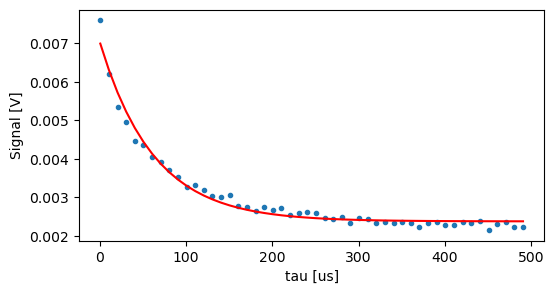

In [14]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

# TLS drive

## TLS spectroscopy

### This cell is only for the first run, to estimate TLS freq

In [15]:
TLS_index = 0

In [16]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level[TLS_index])
TLS_freq_est = np.round(TLS_freq_est * 1E6)
if len(machine.qubits[qubit_index].f_tls) < TLS_index + 2: # need to increase size
    machine.qubits[qubit_index].f_tls.append(int(TLS_freq_est.item()) + 0E6)
    machine.qubits[qubit_index].lo = int(TLS_freq_est.item()) - 200E6
else: # just update the value
    machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.item()))
    machine.qubits[qubit_index].lo = int(TLS_freq_est.item()) - 200E6
machine = Analysis.set_machine(machine)

### This is when we already have calibrated TLS freq saved somewhere

In [42]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 - 200E6
machine = Analysis.set_machine(machine)

In [43]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2024-02-12 12:43:34,708 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-12 12:43:34,715 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r5 for (LO, IF) = (6.171 GHz, -50.000 MHz)
2024-02-12 12:43:42,756 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q5 for (LO, IF) = (4.542 GHz, 200.000 MHz)
2024-02-12 12:43:55,619 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [47]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index+1] + np.arange(-150E6,150E6+1,1E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index, pi_amp_rel = 0.5,
                  n_avg = 1E3, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 607.56s
Execution stopped by user!


resonant frequency: 4869.187 MHz


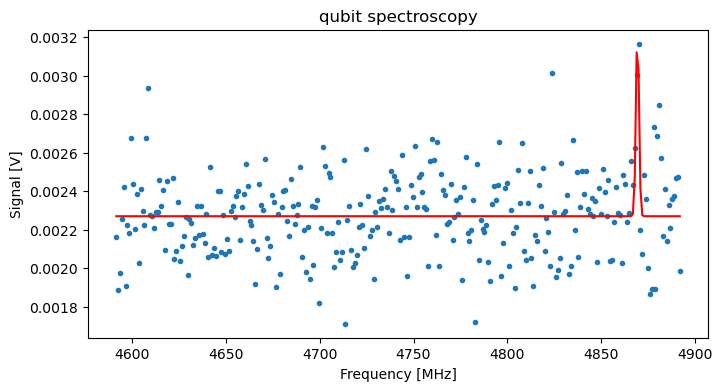

In [46]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
# qubit_freq = int(qubit_freq.tolist())
# # update TLS freq
# machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
# # set the "qubit frequency"
# machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
# machine.qubits[qubit_index].lo = qubit_freq - 200E6
# # save the parameters
# machine = Analysis.set_machine(machine)

## TLS rabi

In [21]:
machine.flux_lines[flux_index].iswap.level[TLS_index] = 0.231
machine = Analysis.set_machine(machine)

In [12]:
machine.qubits[qubit_index].pi_amp_tls[0] = 0.5
machine = Analysis.set_machine(machine)

In [37]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 100 + 0.1, 1)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 4E3, cd_time_qubit = 25E3, cd_time_TLS = 500E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 203.81s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 203.90s


In [38]:
%matplotlib qt
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,method = "decaying_time_rabi", plot_flag = True)

T2rabi: 74.7 ns
rabi_pi_pulse: 328.0 ns
half period: 248.14 ns
Execution stopped by user!


In [30]:
rabi_pi_pulse_tls = 400
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_length_tls.append(rabi_pi_pulse_tls)
    machine.qubits[qubit_index].pi_length_tls[0] = rabi_pi_pulse_tls
else: # just update the value
    machine.qubits[qubit_index].pi_length_tls[TLS_index] = rabi_pi_pulse_tls
    machine.qubits[qubit_index].pi_length_tls[0] = rabi_pi_pulse_tls
    
machine = Analysis.set_machine(machine)

## TLS Power Rabi

In [34]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.1, 5.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, TLS_index = TLS_index,  
                                          n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 500E3, plot_flag = False, machine = machine)

some relative amps > 2, removed from experiment run
some abs amps > 0.5, removed from experiment run
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 47.85s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 47.92s


rabi_pi_pulse_amp: 0.76688 V
half period: 0.6215717 V


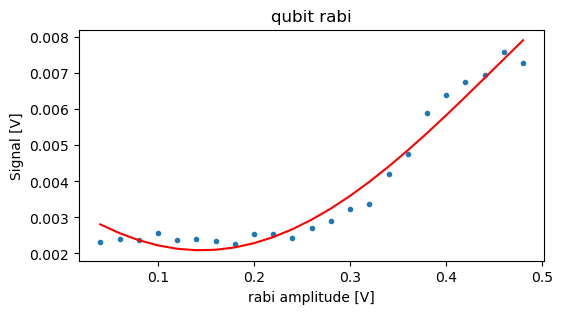

In [35]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [25]:
pi_pulse_amp = 0.4

In [26]:
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_amp_tls.append(pi_pulse_amp)
else: # just update the value
    machine.qubits[qubit_index].pi_amp_tls[TLS_index] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## TLS Ramsey

In [67]:
machine.flux_lines[flux_index].iswap.level[TLS_index] = 0.231
machine = Analysis.set_machine(machine)

In [36]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 180 + 0.1, 2)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_I = Experiment.exp1D.Ramsey.TLS_ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
          n_avg = 4E3, detuning = 10E6, cd_time_qubit = 25E3, cd_time_TLS = 500E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Execution stopped by user!###########                        ] 52.1% (n=2085/4000.0) --> elapsed time: 97.54s


Qubit T2* [ns]: 44.3611921060247
Detuning [MHz]: 8.878568061252334
Exponent n: 0.6766863606715338


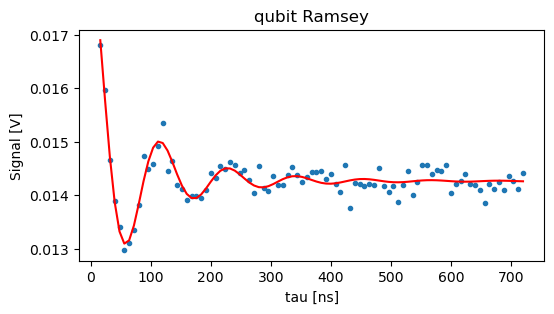

In [80]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_I,plot_flag = True)

## TLS T1 with direct driving

In [81]:
%matplotlib qt
tau_sweep_abs = np.arange(200,1000E3+1,10E3)
machine, tau_sweep_abs, sig_I = Experiment.exp1D.T1.TLS_T1_driving(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 2E3, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 502.85s
Execution stopped by user!


Qubit T1 [us]: 280.35914910883434


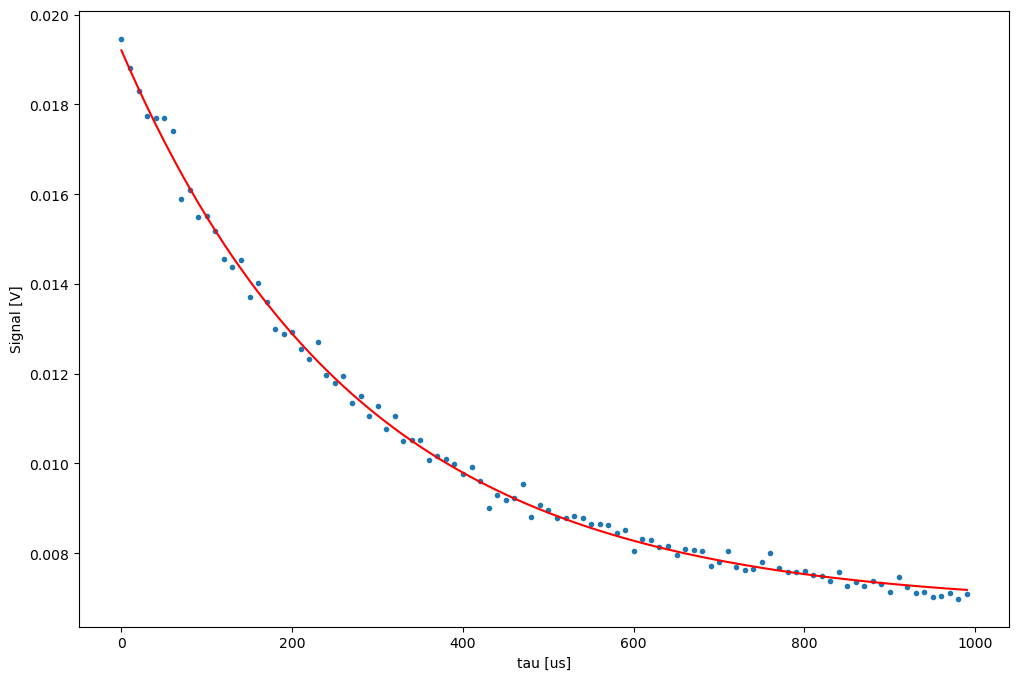

In [82]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_I,method = "exp")

# TLS Dynamical Decoupling

## TLS echo

In [93]:
%matplotlib qt
tau_sweep = np.arange(4, 2E3 + 0.1, 2)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_echo(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          n_avg = 4E3, cd_time_qubit = 25E3, cd_time_TLS = 1000E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 4130.78s
Execution stopped by user!


Qubit T1 [us]: 76.06213887051567


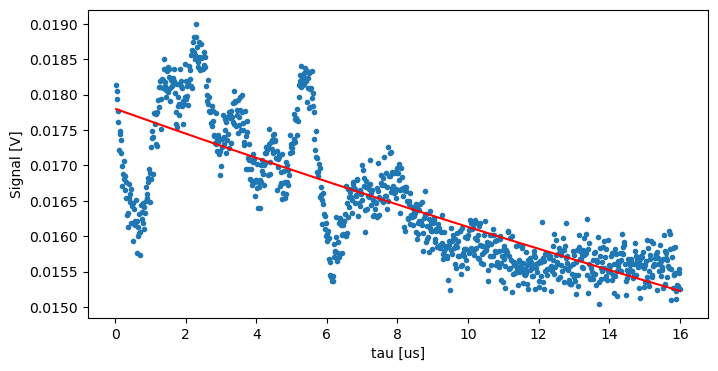

In [94]:
%matplotlib inline
TLS_T2e = Analysis.exp1D.T1(tau_sweep_abs*2,sig_I,method = "exp")

## TLS CPMG2

In [96]:
%matplotlib qt
tau_sweep = np.arange(4, 2E3 + 0.1, 2)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 2, n_avg = 4E3, cd_time_qubit = 25E3, cd_time_TLS = 1000E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 4163.49s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 4163.53s


Qubit T1 [us]: 11.09693096690863


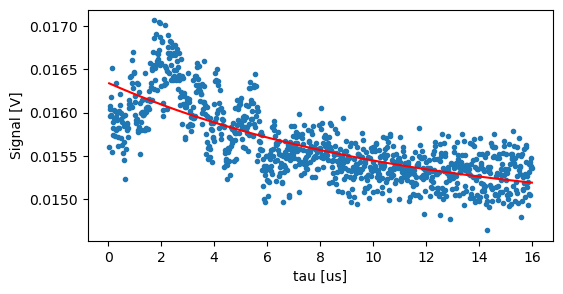

In [100]:
%matplotlib inline
TLS_T2e = Analysis.exp1D.T1(tau_sweep_abs*2,sig_I,method = "exp")

## TLS CPMG4

In [57]:
%matplotlib qt
tau_sweep = np.arange(4, 2000 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 4, n_avg = 10E3, cd_time_qubit = 25E3, cd_time_TLS = 500E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 11191.54s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 11191.59s


## TLS CPMG6

In [58]:
%matplotlib qt
tau_sweep = np.arange(4, 2000 + 0.1, 2)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 6, n_avg = 10E3, cd_time_qubit = 25E3, cd_time_TLS = 500E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 5766.76s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 5766.80s


## TLS CPMG8

In [59]:
%matplotlib qt
tau_sweep = np.arange(4, 2000 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 8, n_avg = 10E3, cd_time_qubit = 25E3, cd_time_TLS = 500E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 11863.80s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 11863.85s


## TLS CPMG12

In [60]:
%matplotlib qt
tau_sweep = np.arange(4, 2000 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 12, n_avg = 10E3, cd_time_qubit = 25E3, cd_time_TLS = 500E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 12536.05s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 12536.10s


## TLS CPMG16

In [61]:
%matplotlib qt
tau_sweep = np.arange(4, 2000 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 16, n_avg = 10E3, cd_time_qubit = 25E3, cd_time_TLS = 500E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 13208.29s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 13208.32s


## TLS CPMG20

In [ ]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 20, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG24

In [ ]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 24, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG28

In [ ]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 28, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG32

In [ ]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 32, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)